computing the KAK decomposition of Ising Hamiltonian to have a good baseline to benchmark adap-zig-zag against

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
import pennylane as qml
from pennylane import X, Y, Z
from pennylane.liealg import even_odd_involution, cartan_decomp, horizontal_cartan_subalgebra, concurrence_involution

import jax
import jax.numpy as jnp
import optax
jax.config.update("jax_enable_x64", True)

n_wires = 3
gens = [X(i) @ X(i+1) for i in range(n_wires-1)]
gens += [Z(i) for i in range(n_wires)]

H = qml.sum(*gens)

g = qml.lie_closure(gens)
g = [op.pauli_rep for op in g]
g

[1 * X(0) @ X(1),
 1 * X(1) @ X(2),
 1.0 * Z(0),
 1.0 * Z(1),
 1.0 * Z(2),
 -1.0 * Y(0) @ X(1),
 -1.0 * X(0) @ Y(1),
 -1.0 * Y(1) @ X(2),
 -1.0 * X(1) @ Y(2),
 1 * Y(0) @ Y(1),
 1 * X(0) @ Z(1) @ X(2),
 1 * Y(1) @ Y(2),
 -1.0 * Y(0) @ Z(1) @ X(2),
 -1.0 * X(0) @ Z(1) @ Y(2),
 1 * Y(0) @ Z(1) @ Y(2)]

In [2]:
involution = concurrence_involution

In [3]:
k, m = cartan_decomp(g, involution)
len(g), len(k), len(m)

(15, 6, 9)

In [4]:
k

[-1.0 * Y(0) @ X(1),
 -1.0 * X(0) @ Y(1),
 -1.0 * Y(1) @ X(2),
 -1.0 * X(1) @ Y(2),
 -1.0 * Y(0) @ Z(1) @ X(2),
 -1.0 * X(0) @ Z(1) @ Y(2)]

In [5]:
for op in H.operands:
    assert not involution(op)

In [6]:
g, k, mtilde, h, _ = horizontal_cartan_subalgebra(k, m, tol=1e-8)
len(g), len(k), len(mtilde), len(h)

(15, 6, 6, 3)

In [7]:
gammas = [np.pi**i % 2 for i in range(1, len(h)+1)]

v = qml.dot(gammas, h)
v_m = qml.matrix(v, wire_order=range(n_wires))
v_m = jnp.array(v_m)

In [8]:
def run_opt(
    loss,
    theta,
    n_epochs=1000,
    lr=0.05,
):
    """Boilerplate JAX optimization"""
    value_and_grad = jax.jit(jax.value_and_grad(loss))
    optimizer = optax.lbfgs(learning_rate=lr, memory_size=100)
    opt_state = optimizer.init(theta)

    energy = []
    gradients = []
    thetas = []

    @jax.jit
    def step(opt_state, theta):
        val, grad_circuit = value_and_grad(theta)
        updates, opt_state = optimizer.update(
            grad_circuit, opt_state, theta, value=val, grad=grad_circuit, value_fn=loss
        )
        theta = optax.apply_updates(theta, updates)

        return opt_state, theta, val

    t0 = datetime.now()
    ## Optimization loop
    for _ in range(n_epochs):
        opt_state, theta, val = step(opt_state, theta)

        energy.append(val)
        thetas.append(theta)
        
    t1 = datetime.now()
    print(f"final loss: {val}; min loss: {np.min(energy)}; after {t1 - t0}")

    return thetas, energy, gradients

final loss: -34.75694578153874; min loss: -34.756945781538754; after 0:00:07.741188


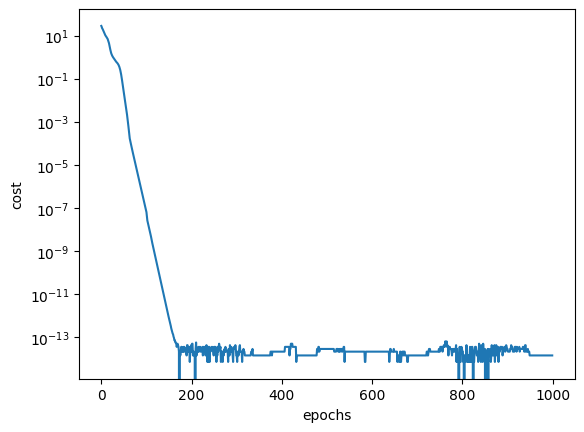

In [9]:
H_m = qml.matrix(H, wire_order=range(n_wires))
H_m = jnp.array(H_m)

def K(theta, k):
    for th, k_j in zip(theta, k):
        qml.exp(-1j * th * k_j.operation())

@jax.jit
def loss(theta):
    K_m = qml.matrix(K, wire_order=range(n_wires))(theta, k)
    A = K_m @ v_m @ K_m.conj().T
    return jnp.trace(A.conj().T @ H_m).real

theta0 = jax.random.normal(jax.random.PRNGKey(0), shape=(len(k),), dtype=float)

thetas, energy, _ = run_opt(loss, theta0, n_epochs=1000, lr=0.05)
plt.plot(energy - np.min(energy))
plt.xlabel("epochs")
plt.ylabel("cost")
plt.yscale("log")
plt.show()

This gives us the optimal values of the parameters $\theta_\text{opt}$
of $K(\theta_\text{opt}) =: K_c.$


In [10]:
theta_opt = thetas[-1]
Kc_m = qml.matrix(K, wire_order=range(n_wires))(theta_opt, k)

In [11]:
theta_opt, k

(Array([ 1.0387191 , -1.31747539,  1.98508923,  0.4142929 , -0.25332093,
        -1.0387191 ], dtype=float64),
 [-1.0 * Y(0) @ X(1),
  -1.0 * X(0) @ Y(1),
  -1.0 * Y(1) @ X(2),
  -1.0 * X(1) @ Y(2),
  -1.0 * Y(0) @ Z(1) @ X(2),
  -1.0 * X(0) @ Z(1) @ Y(2)])

In [12]:
[c * op for c, op in zip(theta_opt, k)]

[-1.0387190968491462 * Y(0) @ X(1),
 1.317475393343197 * X(0) @ Y(1),
 -1.9850892304110668 * Y(1) @ X(2),
 -0.4142929036161686 * X(1) @ Y(2),
 0.25332093345170165 * Y(0) @ Z(1) @ X(2),
 1.038719096849147 * X(0) @ Z(1) @ Y(2)]

The special element $h_0$ from the Cartan subalgebra $\mathfrak{h}$ is
given by rotating the Hamiltonian by the critical $K_c,$

$$h_0 = K_c^\dagger H K_c.$$


In [13]:
h_0_m = Kc_m.conj().T @ H_m @ Kc_m

# decompose h_0_m in terms of the basis of h
basis = [qml.matrix(op, wire_order=range(n_wires)) for op in h]
coeffs = qml.pauli.trace_inner_product(h_0_m, basis)

# ensure that decomposition is correct, i.e. h_0_m is truely an element of just h
h_0_m_recomposed = np.sum([c * op for c, op in zip(coeffs, basis)], axis=0)
print("Decomposition of h_0 is faithful: ", np.allclose(h_0_m_recomposed, h_0_m, atol=1e-10))

# sanity check that the horizontal CSA is Abelian, i.e. all its elements commute
print("All elements in h commute with each other: ", qml.liealg.check_abelian(h))

Decomposition of h_0 is faithful:  True
All elements in h commute with each other:  True


In [18]:
9 + 3 * 16 + 6

63

In [ ]:
 1.2469796037174674 \cdot X_0 X_1 \\
 1.8019377358048387 \cdot Z_2 \\
-0.44504186791262884 \cdot Y_0 Y_1 \\

[(1.2469796037174674-0j) * X(0) @ X(1),
 (1.8019377358048387-0j) * Z(2),
 (-0.44504186791262884+0j) * Y(0) @ Y(1)]

The fact that $K_c^\dagger H K_c \in \mathfrak{h}$ is crucial for this
decomposition to be valid and meaningful. Otherwise, $h_0$ could be
anything and we arrive back at the original problem of decomposing
$e^{-i t h_0}$. Here we know that $h_0$ is composed of elements of an
Abelian Lie algebra $\mathfrak{h}$, such that we can trivially decompose
its unitary as

$$e^{-i t h_0} = e^{-i t \sum_{j=1}^{|\mathfrak{h}|} c_j h_j} = \prod_{j=1}^{|\mathfrak{h}|} e^{-i t c_j h_j}.$$

Overall, this gives us the KhK decomposition of $H,$

$$H = K_c h_0 K_c^\dagger.$$

This trivially reproduces the original Hamiltonian.


In [15]:
H_re = Kc_m @ h_0_m @ Kc_m.conj().T
np.allclose(H_re, H_m)

True

We can now check if the Hamiltonian evolution is reproduced correctly.


In [16]:
t = 1.
U_exact = qml.exp(-1j * t * H)
U_exact_m = qml.matrix(U_exact, wire_order=range(n_wires))
h_0  = qml.dot(coeffs, h)

def U_kak(theta_opt, t):
    qml.adjoint(K)(theta_opt, k)
    qml.exp(-1j * t * h_0)
    K(theta_opt, k)

U_kak_m = qml.matrix(U_kak, wire_order=range(n_wires))(theta_opt, t)

def trace_distance(A, B):
    return 1 - np.abs(np.trace(A.conj().T @ B))/len(A)

trace_distance(U_exact_m, U_kak_m)

np.float64(-4.440892098500626e-16)